<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/TAI/TAI/07_Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the fairness of a ML Model

In this tutorial, we will see how a simple ML model trained on sensitive data can be able to learn how to discriminate against historically protected populations.

Following this line, we will also implement a learning algorithm for addressing exactly this issue and eventually deriving fairer classifiers.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/zangobot/teaching_material/blob/main/07-Fairness.ipynb)

# 00 - Install Librabries

As our python optimization library, we will exploit the free version of GurobiPy, which need to be installed first in our python environment.

This free version does not allow us to train ML models with a lot of variables, but it will suffice for the purpose of this tutorial. Note that a full academic license could be obtained for free requesting it on the [Gurobi official website](https://www.gurobi.com/academia/academic-program-and-licenses/).

In [1]:
try:
  import gurobipy as gp
except ImportError:
  %pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 34.6 MB/s eta 0:00:00


# 01 - Create linear-SVC exploiting Gurobi library

In this tutorial we will create a linear Support Vector Classifier (SVC) from scratch using Gurobipy and Numpy.

SVMs pose the optimization objective defined by:
$$
\begin{align}
\min_{w,b,\xi}&{\frac{||w||^2}{2}+C\sum_{i=1}^n{\xi_i}}\\
s.t.&\,\,\xi_i\geq0\\
&\,\,y_i(x_iw^\top-b)\geq1-\xi_i
\end{align}
$$

For a refresher on linear SVMs, check the well-written [SVM wikipedia article](https://en.wikipedia.org/wiki/Support_vector_machine).

In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB, quicksum

class GurobiSVC:
    def __init__(self,
                 c = 1.,
                 bias_mitigation = None,
                ):
        self.c = c
        self.bias_mitigation = bias_mitigation


    @staticmethod
    def apply_fairness_constraint(constraint,
                                  data, sensitives,
                                  gurobi_model, m_w, m_b):
        assert constraint in ['linearDP', 'linearEO+','linearEO-']

        # ----- Set constraints parameters
        n_samples, n_features = data.shape[0], data.shape[1]

        sens_groups = np.unique(sensitives)
        if len(sens_groups) != 2:
            raise ValueError(f"Only binary sensitive attributes are currently supported; the found unique values of 's' are {sens_groups}")

        gr0_msk = sensitives == sens_groups[0]
        gr1_msk = ~gr0_msk

        if gr0_msk.all() or gr1_msk.all():
            raise RuntimeError("Either one of the two vectors containing a sensitive group is empty")

        # ----- Set constraints
        # b) linear DP, Equal Opp[+,-] on model outputs:
        #     w * (\sum_{i\in{0,[+|-]}}{x_i}/n_{0,[+|-]} - \sum_{i\in{1,[+|-]}}{x_i}/n_{1,[+|-]}) == 0
        if constraint == 'linearDP':
            avg_grfeatures_dist = np.mean(data[gr0_msk], axis=0) - np.mean(data[gr1_msk], axis=0)
            fair_constr = quicksum(m_w[j] * avg_grfeatures_dist[j] for j in range(n_features)) == 0
            gurobi_model.addConstr(fair_constr, name=constraint)

        else: # constraint in ['linearEO+', 'linearEO-']
            # TODO: complete and implement EO constraint
            raise NotImplementedError('EO constraints are not implemented yet.')

        return gurobi_model

    def fit(self, X, y, s=None):
        # ----- model parameters checking and initialization
        if self.c < 0:
            raise ValueError(f"Penalty term must be positive; got {self.c}")

        num_samples, self.n_features_in_ = X.shape[0], X.shape[1]
        self.classes_ = np.unique(y)
        assert self.classes_.tolist() == [-1,1]

        # ----- initialize optimization model
        model = gp.Model()
        model.setParam('OutputFlag',0)

        # ----- add optimization variables
        w = model.addVars(self.n_features_in_, lb=-GRB.INFINITY, ub=GRB.INFINITY)
        b = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY)
        xi = model.addVars(num_samples, lb=0, ub=GRB.INFINITY)

        # ----- define optimization objective: 1/2 * ||w||_2^2 + C * \sum_i{xi_i}
        obj = quicksum(w[j]**2 for j in range(self.n_features_in_))/2 + \
              quicksum(self.c * xi[i] for i in range(num_samples))
        model.setObjective(obj, GRB.MINIMIZE)

        # ----- define optimization constraints
        # 1) soft-margin: y_i * (x_i * w^T + b) >= 1 - xi_i  \forall i \in dataset-indexes
        sm_constrs = (y[i] * (quicksum(w[j] * X[i][j] for j in range(self.n_features_in_)) + b) \
                      >= 1 - xi[i] for i in range(num_samples))
        model.addConstrs(sm_constrs, name="soft-margin")

        # ----- define fairness constraints
        if self.bias_mitigation is not None:
            assert s is not None
            model = GurobiSVC.apply_fairness_constraint(
                constraint=self.bias_mitigation,
                data=X, sensitives=s,
                gurobi_model=model, m_w=w, m_b=b)

        # ----- optimize
        model.optimize()
        if model.Status != 2:
            raise RuntimeError("No optimal solution has been found.")

        # ----- retrieve model coefficients
        self.coef_ = np.array([[w[i].x for i in w.keys()]])
        self.intercept_ = np.array([b.x])

        return self

    def decision_function(self, X):
        raw = np.dot(X, self.coef_.T) + self.intercept_
        return raw.squeeze(-1) # squeeze the outer dimension so that raw.shape == (n_samples,)

    def predict(self, X):
        pred = np.where(self.decision_function(X) >= 0, 1, -1)
        return pred

    def soft_margin_scores(self, X, y): # $xi$ in the standard SVM formulation
        xi = np.maximum(0, 1-y*self.decision_function(X))
        return xi


# 02 - Test plain linear-SVC performances

Now that we have defined the SVC python class, we need to instantiate it and train on a popular dataset for Fair ML: the Compas data.

## 02a - Read data and prepare data for training

In [3]:
# ----- Download data
!gdown 1lgx1QKF26jkrI24x_HYjw9yuDyUnArlp

Downloading...
From: https://drive.google.com/uc?id=1lgx1QKF26jkrI24x_HYjw9yuDyUnArlp
To: /content/clean_compas.csv
100% 118k/118k [00:00<00:00, 71.7MB/s]


In [4]:
# ---- Read data
import pandas as pd

df = pd.read_csv('clean_compas.csv')
df = df.sample(1000, replace=False, random_state=42)
df

,ageCat,race,sex,priorsCount,cChargeDegree,twoYearRecid
8,Greater than 45,1,0,1,0,1
4246,25 - 45,0,1,2,1,-1
544,Less than 25,0,0,0,0,-1
1780,25 - 45,1,1,1,0,1
3940,25 - 45,0,1,0,0,1
...,...,...,...,...,...,...
4427,25 - 45,1,1,3,0,1
644,25 - 45,0,1,3,1,1
1220,25 - 45,0,1,10,0,-1
4803,25 - 45,1,1,1,0,1


In [5]:
# ----- Fix categorical values
np.unique(df['ageCat'])

array(['25 - 45', 'Greater than 45', 'Less than 25'], dtype=object)

In [6]:
for val_idx, categ in enumerate(['Less than 25', '25 - 45', 'Greater than 45']):
    msk = df['ageCat'] == categ
    df.loc[msk, 'ageCat'] = val_idx
df

,ageCat,race,sex,priorsCount,cChargeDegree,twoYearRecid
8,2,1,0,1,0,1
4246,1,0,1,2,1,-1
544,0,0,0,0,0,-1
1780,1,1,1,1,0,1
3940,1,0,1,0,0,1
...,...,...,...,...,...,...
4427,1,1,1,3,0,1
644,1,0,1,3,1,1
1220,1,0,1,10,0,-1
4803,1,1,1,1,0,1


In [7]:
# ---- Split in features, target and sensitive
features = df.columns.tolist()
target = features.pop(-1)
sensitive = 'sex' # sex, race

In [8]:
X = df[features].to_numpy()
y = df[target].to_numpy()
s = df[sensitive].to_numpy()
X.shape, y.shape, s.shape

((1000, 5), (1000,), (1000,))

In [9]:
# ----- Train-validation-test split
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts, s_tr, s_ts = train_test_split(X,y,s, train_size=180, random_state=42)

n_ts = X_ts.shape[0]
X_ts, X_vl = X_ts[:n_ts//2], X_ts[n_ts//2:]
y_ts, y_vl = y_ts[:n_ts//2], y_ts[n_ts//2:]
s_ts, s_vl = s_ts[:n_ts//2], s_ts[n_ts//2:]

X_tr.shape[0], X_ts.shape[0], X_vl.shape[0]

(180, 410, 410)

In [10]:
# ----- Scale features range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_tr = scaler.fit_transform(X_tr)
X_vl = scaler.transform(X_vl)
X_ts = scaler.transform(X_ts)

## 02b - Train model

Since the SVC optimization algorithm contains the free hyperparamters C, we need to tune it in order to retrieve accurate results. Normally, we need to tune it with several rounds of train/validation split, but for the sake of this tutorial, we will use the best value coming from a one-validation-shot.

In [11]:
from sklearn.metrics import accuracy_score

# ----- Validate C param
best_acc = 0
for c in np.linspace(.1,50, num=100).round(3):
    grb_svc = GurobiSVC(c=c)
    grb_svc.fit(X_tr, y_tr)
    curr_acc = round(accuracy_score(y_vl, grb_svc.predict(X_vl)), 3)
    #print(f"{c}: {curr_acc}")
    if curr_acc > best_acc:
        best_acc = curr_acc
        best_c = c

print(f"Best found accuracy: {best_acc} with c={best_c}")

Restricted license - for non-production use only - expires 2025-11-24
Best found accuracy: 0.593 with c=1.108


In [12]:
# ----- Train with best hyper-params configuration
grb_svc = GurobiSVC(c=best_c)
grb_svc.fit(X_tr, y_tr);

## 02c - Test model performances

Once the model is trained we can test the classification performances on the test set:

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_ts, grb_svc.predict(X_ts)))

              precision    recall  f1-score   support

          -1       0.77      0.50      0.61       228
           1       0.57      0.81      0.67       182

    accuracy                           0.64       410
   macro avg       0.67      0.66      0.64       410
weighted avg       0.68      0.64      0.63       410



The data are a bit unbalanced toward the negative class, but otherwise we can achieve a acceptable utility for just deploying a linear model.

# 03 - Fairness

But what happens of we want to test the model performances on the different sensitive groups? lets split the data according to the *sex* sensitive feature: we retrieve the samples coming from either the male and female distributions

In [14]:
male_msk = s_ts == 1
female_msk = ~male_msk

male_acc = classification_report(y_ts[male_msk], grb_svc.predict(X_ts[male_msk]))
female_acc = classification_report(y_ts[female_msk], grb_svc.predict(X_ts[female_msk]))

print(f"Test Accuracy on males:\n{male_acc}")
print(f"\nTest Accuracy on females:\n{female_acc}")

Test Accuracy on males:
              precision    recall  f1-score   support

          -1       0.77      0.35      0.48       165
           1       0.57      0.89      0.70       161

    accuracy                           0.62       326
   macro avg       0.67      0.62      0.59       326
weighted avg       0.67      0.62      0.59       326


Test Accuracy on females:
              precision    recall  f1-score   support

          -1       0.76      0.92      0.83        63
           1       0.38      0.14      0.21        21

    accuracy                           0.73        84
   macro avg       0.57      0.53      0.52        84
weighted avg       0.67      0.73      0.68        84



From the report above we can observe three main issues:


1.   There is a huge difference in number of samples between the two sensitive groups: 326 (male population) against 84 (female one)
2.   There is a big accuracy gap between the two sensitive groups: 62% for males, while on the female subsamples we obtain an average accuracy of 73%
3.   there is a huge recall difference between the two sensitive groups (remember that the recall metrics measure the total number of samples that the model is able to select for a particular class): we observe that for the positive class (+1) we have a recall rate of 89% on the male population, while only a 14% on the female one. While the situation is inverted for the negative class. This means that the model learnt a really big correlation between being male and belonging to the positive class against being female and belonging to the negative one.



In [15]:
!gdown 1VGM4jSUAXzylcJJwB5HxjEXYFHpt22tn # download ploy.py

Downloading...
From: https://drive.google.com/uc?id=1VGM4jSUAXzylcJJwB5HxjEXYFHpt22tn
To: /content/plot.py
100% 2.29k/2.29k [00:00<00:00, 6.25MB/s]


The 3rd point above may be justified by the fact that in the negative class we observe 3 times more samples belonging to the female population than the one that are observed for the positive class. Then a simple model like the linear one that we implemented simply learnt this spurious correlation!

Total samples: 410
Class distribution:
	class -1: 228
	class 1: 182
Sensitive distribution:
	group 0: 84
	group 1: 326
Class-sensitive distribution:
	class -1, group 0: 63
	class -1, group 1: 165
	class 1, group 0: 21
	class 1, group 1: 161


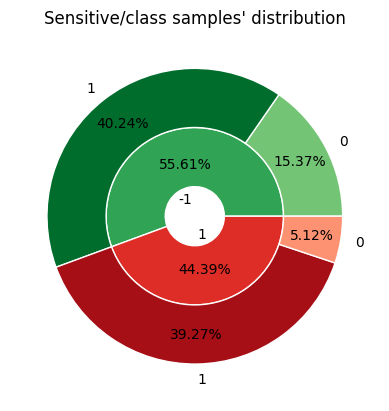

In [16]:
from plot import plot_distributions_sunburst
plot_distributions_sunburst(y_ts, s_ts)

## 03a - Define fairness metrics
Once we noticed this disparities in accuracies for the different sensitive groups, we wish to define a simple quantity for measuring the dependency of the sensitive feature towards the model predictions: Difference of Demographic Parity (DDP)!
Simply put, DDP measures the average prediction difference between the different sensitive groups:
$$
\left|\,\frac{1}{n_0}\sum_{i=1,s=0}^{n_0}{f(x_i)} - \frac{1}{n_1}\sum_{i=1,s=1}^{n_1}{f(x_i)}\,\right|
$$
Similarly to DDP, we can also define the Difference of Equal Opportunity (DEO), where the average is computed between the samples belonging to a predefined class only (either 1 or -1 in this tutorial).

In [17]:
def difference_demographic_parity(model, samples, sensitive):
    groups = np.unique(sensitive)
    assert len(groups) == 2

    gr0 = groups[0]
    gr0_msk = sensitive == gr0

    avg_pred_gr0 = model.predict(samples[gr0_msk]).mean()
    avg_pred_gr1 = model.predict(samples[~gr0_msk]).mean()
    ddp = np.abs(avg_pred_gr0 - avg_pred_gr1)
    return round(ddp, 3)

def difference_equal_opportunity(model, samples, sensitive, labels, target):
    groups = np.unique(sensitive)
    assert len(groups) == 2

    gr0 = groups[0]
    gr0_msk = sensitive == gr0
    gr1_msk = ~gr0_msk
    trg_mak = labels == target
    gr0_target = gr0_msk & trg_mak
    gr1_target = gr1_msk & trg_mak

    avg_pred_gr0 = model.predict(samples[gr0_target]).mean()
    avg_pred_gr1 = model.predict(samples[gr1_target]).mean()
    deo = np.abs(avg_pred_gr0 - avg_pred_gr1)
    return round(deo, 3)

## 03b - Test fairness metrics on previously trained SVC

In [18]:
ddp = difference_demographic_parity(grb_svc, X_ts, s_ts)
deo_pos = difference_equal_opportunity(grb_svc, X_ts, s_ts, y_ts, 1)
deo_neg = difference_equal_opportunity(grb_svc, X_ts, s_ts, y_ts, -1)

print(f"Difference of Demographic Parity (DDP): {ddp}")
print(f"Difference of Equal Opportunity on positive class (DEO+): {deo_pos}")
print(f"Difference of Equal Opportunity on negative class (DEO-): {deo_neg}")

Difference of Demographic Parity (DDP): 1.356
Difference of Equal Opportunity on positive class (DEO+): 1.503
Difference of Equal Opportunity on negative class (DEO-): 1.15


## 03d - Improve model fairness: In-processing

In order to make our SVC fairer, we wish to impose a fairness constraint within the optimization process which force the DDP measure to be equal to 0.

The DDP constraint for a linear model can be written as:
$$
\begin{align}
&\frac{1}{n_0}\sum_{i=1,s=0}^{n_0}{(x_iw^\top-b)} - \frac{1}{n_1}\sum_{i=1,s=1}^{n_1}{(x_iw^\top-b)}=0⇒\\
⇒\,&w\,\left(\frac{1}{n_0}\sum_{i=1,s=0}^{n_0}{x_i} - \frac{1}{n_1}\sum_{i=1,s=1}^{n_1}{x_i}\right)
\end{align}
$$

In [19]:
def apply_fairness_constraint(constraint,
                              data, sensitives,
                              gurobi_model, m_w, m_b, m_xi):
    assert constraint in ['linearDP', 'linearEO+','linearEO-']

    # ----- Set constraints parameters
    n_samples, n_features = data.shape[0], data.shape[1]

    sens_groups = np.unique(sensitives)
    if len(sens_groups) != 2:
        raise ValueError(f"Only binary sensitive attributes are currently supported; the found unique values of 's' are {sens_groups}")

    gr0_msk = sensitives == sens_groups[0]
    gr1_msk = ~gr0_msk

    if gr0_msk.all() or gr1_msk.all():
        raise RuntimeError("Either one of the two vectors containing a sensitive group is empty")

    # ----- Set constraints
    # b) linear DP, Equal Opp[+,-] on model outputs:
    #     w * (\sum_{i\in{0,[+|-]}}{x_i}/n_{0,[+|-]} - \sum_{i\in{1,[+|-]}}{x_i}/n_{1,[+|-]}) == 0
    if constraint == 'linearDP':
        avg_grfeatures_dist = np.mean(data[gr0_msk], axis=0) - np.mean(data[gr1_msk], axis=0)
        fair_constr = quicksum(m_w[j] * avg_grfeatures_dist[j] for j in range(n_features)) == 0
        gurobi_model.addConstr(fair_constr, name=constraint)
    else:
        raise NotImplementedError('EO constraints are not implemented yet.')

    return gurobi_model

Reperform one-shot validation for finding the best *c* hyperparameter

In [20]:
from sklearn.metrics import accuracy_score

# ----- Validate C param
best_acc = 0
for c in np.linspace(.1,50,num=100).round(3):
    fair_grb_svc = GurobiSVC(c=c, bias_mitigation='linearDP')
    fair_grb_svc.fit(X_tr, y_tr, s_tr)
    curr_acc = round(accuracy_score(y_vl, fair_grb_svc.predict(X_vl)), 3)
    #print(f"{c}: {curr_acc}")
    if curr_acc > best_acc:
        best_acc = curr_acc
        best_c = c

print(f"Best found accuracy: {best_acc} with c={best_c}")

Best found accuracy: 0.612 with c=5.644


In [21]:
fair_grb_svc = GurobiSVC(c=best_c, bias_mitigation='linearDP')
fair_grb_svc.fit(X_tr, y_tr, s_tr);

Test utility and fairness performances of fair linear-SVC

In [22]:
print(classification_report(y_ts, fair_grb_svc.predict(X_ts)))

              precision    recall  f1-score   support

          -1       0.71      0.50      0.59       228
           1       0.55      0.75      0.63       182

    accuracy                           0.61       410
   macro avg       0.63      0.63      0.61       410
weighted avg       0.64      0.61      0.61       410



From the report above we observe that in order to reduce the model discrimination we loose more or less 3% of accuracy (64% → 61%)

In [23]:
male_msk = s_ts == 1
female_msk = ~male_msk

male_acc = classification_report(y_ts[male_msk], fair_grb_svc.predict(X_ts[male_msk]))
female_acc = classification_report(y_ts[female_msk], fair_grb_svc.predict(X_ts[female_msk]))

print(f"Test Accuracy on males:\n{male_acc}")
print(f"\nTest Accuracy on females:\n{female_acc}")

Test Accuracy on males:
              precision    recall  f1-score   support

          -1       0.69      0.56      0.62       165
           1       0.62      0.75      0.68       161

    accuracy                           0.65       326
   macro avg       0.66      0.65      0.65       326
weighted avg       0.66      0.65      0.65       326


Test Accuracy on females:
              precision    recall  f1-score   support

          -1       0.82      0.37      0.51        63
           1       0.29      0.76      0.42        21

    accuracy                           0.46        84
   macro avg       0.55      0.56      0.46        84
weighted avg       0.69      0.46      0.48        84



But the accuracy lost is counterbalanced by big improvements on the fairness measures: now the difference in recall rates are not as huge as before and the DDP and DEO below are much lower!

In [24]:
ddp = difference_demographic_parity(fair_grb_svc, X_ts, s_ts)
deo_pos = difference_equal_opportunity(fair_grb_svc, X_ts, s_ts, y_ts, 1)
deo_neg = difference_equal_opportunity(fair_grb_svc, X_ts, s_ts, y_ts, -1)

print(f"Difference of Demographic Parity (DDP): {ddp}")
print(f"Difference of Equal Opportunity on positive class (DEO+): {deo_pos}")
print(f"Difference of Equal Opportunity on negative class (DEO-): {deo_neg}")

Difference of Demographic Parity (DDP): 0.149
Difference of Equal Opportunity on positive class (DEO+): 0.033
Difference of Equal Opportunity on negative class (DEO-): 0.385
